In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib as mpl
import pickle
from copy import copy
from tqdm import tqdm_notebook as tqdm
from importlib import reload

import readdy_learn.example.mapk as mapk

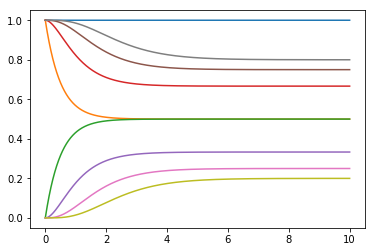

In [2]:
mapk.TIMESTEP = 1e-3
mapk.N_STIMULUS = 1
mapk.INITIAL_STATES[0][0] = mapk.N_STIMULUS
cfg = mapk.MAPKConfiguration()
time, count, dcount_dt = mapk.generate_lma(10, cfg)

plt.plot(time, count)
plt.show()

In [3]:
activities = []
X = np.logspace(-3, 3, num=100)
for N_STIMULUS in tqdm(X):
    mapk.TIMESTEP = 1e-3
    mapk.INITIAL_STATES[0][0] = N_STIMULUS
    time, count, dcount_dt = mapk.generate_lma(10, cfg)
    activities.append(count[-1, -1])
mapk.TIMESTEP = 1e-3
mapk.N_STIMULUS = 1
mapk.INITIAL_STATES[0][0] = mapk.N_STIMULUS
cfg = mapk.MAPKConfiguration()

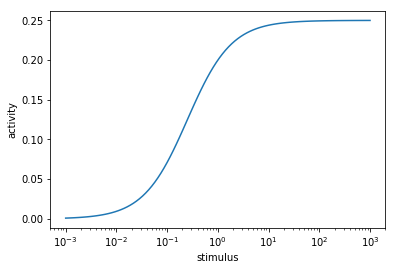

In [4]:
plt.semilogx(X, activities)
plt.xlabel('stimulus')
plt.ylabel('activity')
plt.show()

In [2]:
cfg = mapk.MAPKConfiguration()

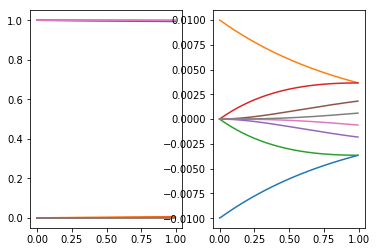

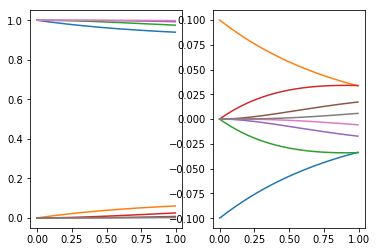

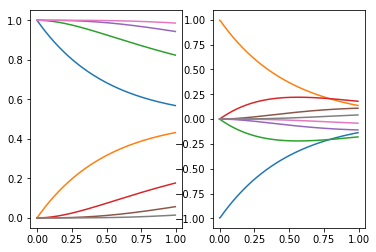

In [3]:
data = []
for N_STIMULUS in [1e-2, 1e-1, 1e0]:
    # mapk.TIMESTEP = 3e-2 # works well
    mapk.TIMESTEP = 5e-3 # 2.7 works better
    
    X = copy(mapk.INITIAL_STATES)
    X[0][0] = N_STIMULUS
    mapk.INITIAL_STATES = X
    time, count, dcount_dt = mapk.generate_lma(1, cfg)
    # time, count, dcount_dt = mapk.generate_kmc(0, .003, n_realizations=15, njobs=5)
    data.append((time, count, dcount_dt))
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(time, count[:, 1:])
    ax2.plot(time, dcount_dt[:, 1:])
    # plt.plot(time, count[:, 1:])
    f.show()

In [4]:
time = np.concatenate([data[i][0] for i in range(len(data))])
counts = np.concatenate([data[i][1] for i in range(len(data))])
dcounts_dt = np.concatenate([data[i][2] for i in range(len(data))])

# shuffle
N = np.arange(len(time))
np.random.shuffle(N)
shuffled_time = time[N]
shuffled_counts = counts[N]
shuffled_dcounts_dt = dcounts_dt[N]

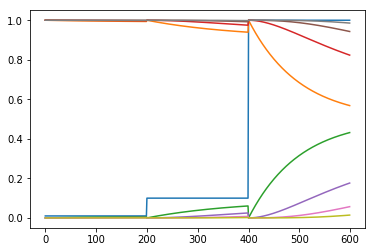

In [5]:
plt.plot(counts)
plt.show()

In [6]:
len(time)

600

In [5]:
result = mapk.solve_grid(cfg, shuffled_counts, shuffled_dcounts_dt, l1_ratios=(1.,), 
                         alphas=np.logspace(-10, -6, num=100), njobs=6)

Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.32194114847e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
155 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
173 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.09749876549e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
178 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.20450354026e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
175 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.59228279334e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
184 / 5000 iterations
Trying tolerance 1e-16

Process ForkPoolWorker-4:


KeyboardInterrupt: 

In [59]:
alphas = np.array([res[0] for res in result])
sort = np.argsort(alphas)
alphas = alphas[sort]
estimated_rates = np.array([res[2] for res in result])
estimated_rates = estimated_rates[sort]
l1_errs = np.sum(np.abs(estimated_rates - cfg.rates), axis=1)

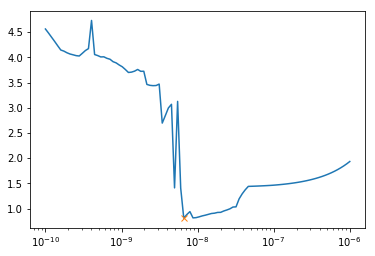

In [60]:
plt.semilogx(alphas, l1_errs)
plt.plot([alphas[np.argmin(l1_errs)]], [l1_errs[np.argmin(l1_errs)]], 'x')

In [61]:
alphas[np.argmin(l1_errs)]

6.5793322465756821e-09

In [62]:
best_estimated_rates = estimated_rates[np.argmin(l1_errs)]

In [63]:
np.abs(((estimated_rates[0][:8] - cfg.rates[:8]) / cfg.rates[:8]))

array([  5.86468163e-04,   1.29630702e-03,   2.90372476e-04,
         3.32990535e-01,   2.17953332e-03,   5.48162110e-01,
         3.06802583e-03,   6.75099448e-01])

In [64]:
np.abs(((best_estimated_rates[:8] - cfg.rates[:8]) / cfg.rates[:8]))

array([  5.86648691e-04,   1.29676475e-03,   2.97691103e-04,
         1.33353334e-02,   6.38004000e-04,   8.04345826e-04,
         4.24869109e-02,   4.06597549e-01])

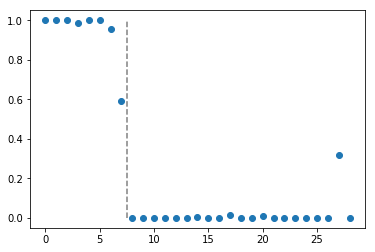

In [65]:
plt.plot(best_estimated_rates, 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

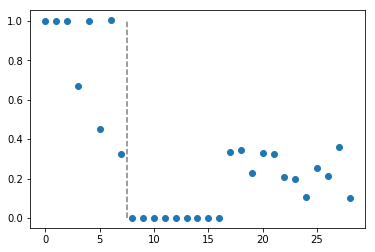

In [66]:
plt.plot(estimated_rates[0], 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

In [ ]:
cv_result = mapk.cv(cfg, shuffled_counts, shuffled_dcounts_dt, 
                    alphas=np.logspace(-9, -7.5, 20), n_splits=len(shuffled_counts)//2, njobs=8)

validating across grid with 20 alphas, 1 lambdas, 1 cutoffs with 1 realizations


Running kfold with n_splits=300
Test: [0 1]
Test: [0 1]
Solving for tolerance 1e-16
Running kfold with n_splits=300
Test: [0 1]
Solving for tolerance 1e-16
Running kfold with n_splits=300
Solving for tolerance 1e-16
Running kfold with n_splits=300
Test: [0 1]
Solving for tolerance 1e-16
Running kfold with n_splits=300
Test: [0 1]
Solving for tolerance 1e-16
Running kfold with n_splits=300
Running kfold with n_splits=300
Running kfold with n_splits=300
Test: [0 1]
Solving for tolerance 1e-16
Test: [0 1]
Solving for tolerance 1e-16
Test: [0 1]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [2 3]
Solving for tolerance 1e-16
Test: [4 5]
Solving for tolerance 1e-16
Test: [4 5]
Test: [4 5]
Solving for tolerance 1e-16
Solving for 

Test: [50 51]
Solving for tolerance 1e-16
Test: [44 45]
Solving for tolerance 1e-16
Test: [50 51]
Solving for tolerance 1e-16
Test: [48 49]
Solving for tolerance 1e-16
Test: [50 51]
Solving for tolerance 1e-16
Test: [46 47]
Solving for tolerance 1e-16
Test: [50 51]
Solving for tolerance 1e-16
Test: [52 53]
Solving for tolerance 1e-16
Test: [46 47]
Solving for tolerance 1e-16
Test: [52 53]
Solving for tolerance 1e-16
Test: [50 51]
Solving for tolerance 1e-16
Test: [44 45]
Solving for tolerance 1e-16
Test: [52 53]
Solving for tolerance 1e-16
Test: [48 49]
Solving for tolerance 1e-16
Test: [52 53]
Solving for tolerance 1e-16
Test: [54 55]
Solving for tolerance 1e-16
Test: [54 55]
Solving for tolerance 1e-16
Test: [48 49]
Solving for tolerance 1e-16
Test: [46 47]
Solving for tolerance 1e-16
Test: [52 53]
Solving for tolerance 1e-16
Test: [54 55]
Solving for tolerance 1e-16
Test: [50 51]
Solving for tolerance 1e-16
Test: [54 55]
Solving for tolerance 1e-16
Test: [56 57]
Solving for toleranc

Test: [92 93]
Solving for tolerance 1e-16
Test: [92 93]
Solving for tolerance 1e-16
Test: [98 99]
Solving for tolerance 1e-16
Test: [102 103]
Solving for tolerance 1e-16
Test: [102 103]
Solving for tolerance 1e-16
Test: [98 99]
Solving for tolerance 1e-16
Test: [86 87]
Solving for tolerance 1e-16
Test: [94 95]
Solving for tolerance 1e-16
Test: [102 103]
Solving for tolerance 1e-16
Test: [100 101]
Solving for tolerance 1e-16
Test: [94 95]
Solving for tolerance 1e-16
Test: [104 105]
Solving for tolerance 1e-16
Test: [104 105]
Solving for tolerance 1e-16
Test: [100 101]
Solving for tolerance 1e-16
Test: [96 97]
Solving for tolerance 1e-16
Test: [88 89]
Solving for tolerance 1e-16
Test: [104 105]
Solving for tolerance 1e-16
Test: [96 97]
Solving for tolerance 1e-16
Test: [102 103]
Solving for tolerance 1e-16
Test: [106 107]
Solving for tolerance 1e-16
Test: [106 107]
Solving for tolerance 1e-16
Test: [102 103]
Solving for tolerance 1e-16
Test: [106 107]
Solving for tolerance 1e-16
Test: [9

In [75]:
alphas = []
scores = []
all_scores = []
scores_std = []
for res in cv_result['cv_result']:
    alphas.append(res['alpha'])
    scores.append(np.mean(res['score']))
    scores_std.append(np.std(res['score']))
    all_scores.append(res['score'])
alphas = np.array(alphas)
scores = np.array(scores)
scores_std = np.array(scores_std)
all_scores = np.array(all_scores)
N = np.argsort(alphas)
alphas = alphas[N]
scores = scores[N]
scores_std = scores_std[N]
all_scores = all_scores[N]

In [76]:
all_scores.shape

(10, 50)

In [77]:
from sklearn.model_selection import KFold

In [91]:
data = np.arange(10)
splitter = KFold(n_splits=len(data))
for train, test in splitter.split(data):
    print(f'train: {train}, test: {test}')

train: [1 2 3 4 5 6 7 8 9], test: [0]
train: [0 2 3 4 5 6 7 8 9], test: [1]
train: [0 1 3 4 5 6 7 8 9], test: [2]
train: [0 1 2 4 5 6 7 8 9], test: [3]
train: [0 1 2 3 5 6 7 8 9], test: [4]
train: [0 1 2 3 4 6 7 8 9], test: [5]
train: [0 1 2 3 4 5 7 8 9], test: [6]
train: [0 1 2 3 4 5 6 8 9], test: [7]
train: [0 1 2 3 4 5 6 7 9], test: [8]
train: [0 1 2 3 4 5 6 7 8], test: [9]


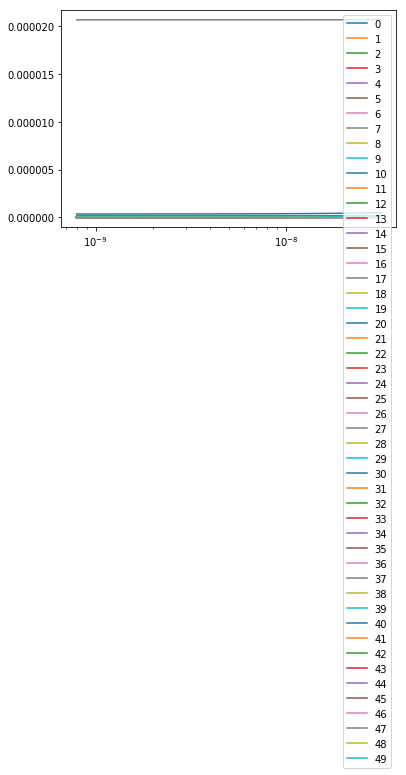

In [79]:
plt.xscale('log')
for fold in range(all_scores.shape[1]):
    plt.plot(alphas, -all_scores[:, fold], label=f'{fold}')
plt.legend()

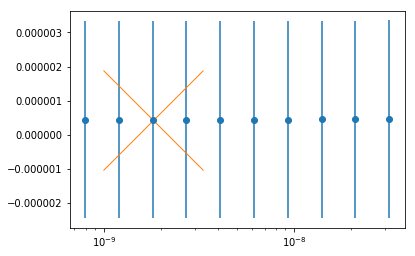

In [81]:
plt.xscale('log')
plt.errorbar(alphas, -scores, yerr=scores_std, fmt='o')
plt.plot([alphas[np.argmin(-scores)]], [-scores[np.argmin(-scores)]], 'x', markersize=100)
#plt.ylim([4.447e8, 4.46e8])

In [82]:
rates = mapk.solve(cfg, shuffled_counts, shuffled_dcounts_dt, alpha=alphas[np.argmin(-scores)], l1_ratio=1.)

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.80117352833e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
228 / 5000 iterations


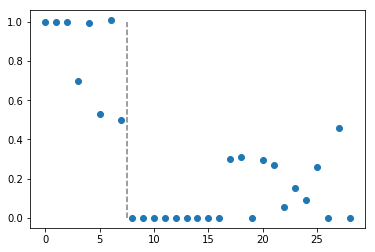

In [83]:
plt.plot(rates, 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

In [14]:
alphas[X]

8.1331055822669358e-10

In [38]:
import readdy_learn.analyze.cross_validation as cross_validation
import readdy_learn.analyze.tools as tools

In [43]:
traj = tools.Trajectory(shuffled_counts, time_step=mapk.TIMESTEP)
traj.dcounts_dt = shuffled_dcounts_dt
cv = cross_validation.CrossValidation([traj], cfg.bfc())

In [51]:
X = cv._obtain_trajs_subset(np.arange(100))

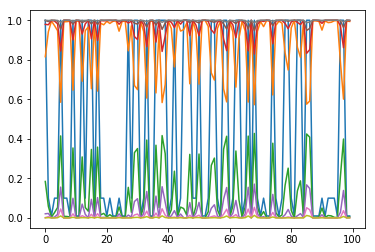

In [53]:
plt.plot(X.counts)

### generating hocus bogus double conversions

In [53]:
tuples = tuple((i, j) for i in range(1, 9) for j in range(9) if j > i)

In [54]:
pairs = tuple((tuples[i], tuples[j]) for i in range(len(tuples)) for j in range(len(tuples)) if j != i
             and tuples[i][0] == tuples[j][0] and tuples[i][1] - tuples[j][1] == -1 and tuples[i][1] % 2 == 1)

In [55]:
pairs = [(pairs[i][0], pairs[i][1]) for i in range(len(pairs))] 
        + [(pairs[i][1], pairs[i][0]) for i in range(len(pairs))]

In [56]:
pairs

[((1, 3), (1, 4)),
 ((1, 5), (1, 6)),
 ((1, 7), (1, 8)),
 ((2, 3), (2, 4)),
 ((2, 5), (2, 6)),
 ((2, 7), (2, 8)),
 ((3, 5), (3, 6)),
 ((3, 7), (3, 8)),
 ((4, 5), (4, 6)),
 ((4, 7), (4, 8)),
 ((5, 7), (5, 8)),
 ((6, 7), (6, 8)),
 ((1, 4), (1, 3)),
 ((1, 6), (1, 5)),
 ((1, 8), (1, 7)),
 ((2, 4), (2, 3)),
 ((2, 6), (2, 5)),
 ((2, 8), (2, 7)),
 ((3, 6), (3, 5)),
 ((3, 8), (3, 7)),
 ((4, 6), (4, 5)),
 ((4, 8), (4, 7)),
 ((5, 8), (5, 7)),
 ((6, 8), (6, 7))]